In [1]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

<IPython.core.display.Javascript object>

In [2]:
import pandas as pd
import numpy as np
import pathlib
import matplotlib.pyplot as plt
import matplotlib.lines as mlines
import seaborn as sns

In [3]:
# read in data

base_path = pathlib.Path.cwd().parent.parent / 'datasets'
inv_path = base_path / 'inv_urls.csv'
repat_path = base_path / 'repatriation_urls.csv'
full_path = base_path / 'fulltext.pckl.gz'
meta_path = base_path / 'metadata.pckl.gz'

inv_urls = pd.read_csv(inv_path)
repat_urls = pd.read_csv(repat_path)
fulltext = pd.read_pickle(full_path, compression='gzip')
metadata = pd.read_pickle(meta_path, compression='gzip')

In [4]:
# controlled vocabulary list
vocab = ['ceremon',
        'death rite',
        'excavat', 
        'burial site',
        'shell bead',
        'culturally unidentifiable human remains',
        'burial mound']

# list of phrases similar to 'unidentifiable human remains'
unident_vocab = ['culturally unidentifiable native american human remains',
                 'culturally unidentifiable native american remains',
                 'unidentifiable native american remains',
                 'unidentifiable native american',
                 'culturally unidentifiable human remains',
                 'unidentifiable human remains',
                 'culturally unidentifiable', 
                 'unidentifiable remains',
                 'unidentifiable',
                 'culturally unident',
                 'unident']

In [5]:
# create dictionary to 
# key is a phrase in unident_vocab
# value is list of all phrases in unident_vocab which are supersets of key
unident_dict = {x:[y for y in unident_vocab if (x in y) & (x!=y)] \
                                                    for x in unident_vocab}

In [6]:
# make a copy of fulltext, with all text lowercase
vocab_df = fulltext.copy()
vocab_df = vocab_df.applymap(str.lower)

In [7]:
# create binary column for each phrase in controlled vocabulary
for phrase in vocab:
    vocab_df[phrase] = vocab_df.messy_full.map(lambda x: phrase in x)
for phrase in unident_vocab:
    vocab_df[phrase] = vocab_df.messy_full.map(lambda x: phrase in x)

In [8]:
def context(phrase, text):
    
    # split text approximately into sentences
    sentences = text.split('.')
    
    # check each sentence for phrase
    for x in sentences:
        if phrase in x:
            # return sentence if phrase is in it
            return x
        
    # return "None" if phrase not found in any sentence
    return "None"

def vocab_info(phrase, parents):
    
    # get total number of documents containing phrase
    num_total = vocab_df[phrase].sum()
    
    # return if phrase does not appear in any documents
    if num_total == 0:
        return 0, 0, 0, 'None', 'None'
    
    # get indices of documents containing phrase
    inv = [x for x in list(vocab_df[vocab_df[phrase]==1].index) if x[0]=='I']
    repat = [x for x in list(vocab_df[vocab_df[phrase]==1].index) if x[0]=='R']
    
    # get number of documents containing phrase
    num_inv = len(inv)
    num_repat = len(repat)
    
    
    for parent in parents:
        if len(inv)!=0: 
            
            # get indices of documents containing specified superset
            parent_inv = [x for x in list(vocab_df[vocab_df[parent]==1].index) \
                                                                        if x[0]=='I']
            # only consider documents which contain the phrase without superset
            inv = set(inv) - set(parent_inv)
            
            if len(inv)==0:
                # phrase does not appear in any documents without superset
                inv_sample_context = 'same as \"{}\"'.format(parent)
                
        if len(repat)!=0: 
            # get indices of documents containing specified superset
            parent_repat = [x for x in list(vocab_df[vocab_df[parent]==1].index) \
                                                                        if x[0]=='R']
            # only consider documents which contain the phrase without superset
            repat = set(repat) - set(parent_repat)
            
            if len(repat)==0:
                # phrase does not appear in any documents without superset
                repat_sample_context = 'same as \"{}\"'.format(parent)
                
        if len(inv)==0 and len(repat)==0:
            # break loop if both index sets are empty
            break

    inv = list(inv)    
    repat = list(repat)
    
    if len(inv)!=0:
        # provide context sample that does not also contain superset
        inv_sample_context = context(phrase, vocab_df.loc[inv[-1], 'messy_full'])
    if len(repat)!=0:
        # provide context sample that does not also contain superset
        repat_sample_context = context(phrase, vocab_df.loc[repat[-1], 'messy_full'])
    return num_total, num_inv, num_repat, inv_sample_context, repat_sample_context

In [9]:
# create dataframe with info on phrases similar to 'unidentifiable human remains'
unident_results = pd.DataFrame(data={phrase: vocab_info(phrase, parents) \
                                     for phrase, parents in unident_dict.items()}, 
                             index=['Number of Total Documents', 
                                    'Number of Notices of Inventory Completion', 
                                    'Number of Notices of Intent to Repatriate', 
                                    'Sample Inventory Context', 
                                    'Sample Repatriation Context']) \
                    .T.sort_values('Number of Total Documents')

In [10]:
# create dataframe with info on controlled vocab phrases
vocab_results = pd.DataFrame(data={phrase: vocab_info(phrase, []) for phrase in vocab}, 
                             index=['Number of Total Documents', 
                                    'Number of Notices of Inventory Completion', 
                                    'Number of Notices of Intent to Repatriate', 
                                    'Sample Inventory Context', 
                                    'Sample Repatriation Context']) \
                    .T.sort_values('Number of Total Documents')

In [11]:
# display individual dataframes with full text samples
pd.set_option('display.max_colwidth', -1)
display(vocab_results)
display(unident_results)

,Number of Total Documents,Number of Notices of Inventory Completion,Number of Notices of Intent to Repatriate,Sample Inventory Context,Sample Repatriation Context
burial mound,75,61,14,100-500) burial mound that was damaged by trenching in 1917,"\n in 1977, these items were recovered during legally authorized \nexcavations of portions of two burial mounds at the winnibigoshish dam \nsite (21 ic 4) near\n\n[[page 44924]]\n\nwinnibigoshish dam, chippewa national forest, itasca county, mn"
culturally unidentifiable human remains,126,124,2,"16, the secretary of the interior may make a recommendation for a transfer of control of culturally unidentifiable human remains","\n in july 2003, the flandreau santee sioux tribe of south dakota submitted a request to the archaeological research center for repatriation of the culturally unidentifiable human remains and funerary objects from eastern, central, and northwestern south dakota, and southeastern montana, including the 14 unassociated funerary objects from the daugherty mounds and scalp creek sites, on behalf of the cheyenne river sioux tribe of the cheyenne river reservation, south dakota; crow creek sioux tribe of the crow creek reservation, south dakota; flandreau santee sioux tribe of south dakota; iowa tribe of oklahoma; lower sioux indian community in the state of minnesota; northern cheyenne tribe of the northern cheyenne indian reservation, montana; oglala sioux tribe of the pine ridge reservation, south dakota; omaha tribe of nebraska; otoe-missouria tribe of indians, oklahoma; prairie island indian community in the state of minnesota; rosebud sioux tribe of the rosebud indian reservation, south dakota; sac & fox tribe of the mississippi in iowa; santee sioux nation, nebraska; sisseton-wahpeton oyate of the lake traverse reservation, south dakota; three affiliated tribes of the fort berthold reservation, north dakota; upper sioux indian community, minnesota; and yankton sioux tribe of south dakota"
shell bead,404,290,114,"the associated funerary objects, including shell beads and shell gorgets, stone and bone tools, ornaments, trade beads and metal trade objects were also excavated from these burials and were documented in reports generated in the 1980s by university of tennessee and university of georgia professional staff","the 5,508 unassociated funerary objects (207 inventory numbers) are 2 abalone shell containers; 2 abraders; 1 arrow straightener; 36 arrow points (3 arrow points, 5 chalcedony, 4 chalcedony and chert, 6 obsidian, 1 red carnelian, 5 stone, 12 obsidian and chalcedony); 2 asphaltum pieces; 3 balls (1 granite, 1 sandstone, and 1 wood); 9 basket fragments, 1 bag with tiny beads and fragments and 5,156 individual beads (15 clam shell beads, 10 pismo clam shell beads, 4 amethystine beads, 2,010 trade beads, 1 serpetine bead, 51 steatite beads, 2 stone beads, 22 red and white beads, 307 olivella beads, 365 red beads, 2,065 blue beads, 42 black beads, 113 green beads, 111 white, 1 yellow, 19 amber beads, 3 pink beads, 3 miscellaneous beads, 1 unknown bead, 3 soapstone beads, 1 crystal beads, 2 shell beads, and 5 tubular beads); 2 boiling stones; 1 glass bottle neck; 3 bowls (1 sandstone, 1 stone, and 1seatite); 20 bowl fragments (5 steatite, 7 sandstone, 1 wooden, and 7 soapstone); 1 brush; 1 bull roarer fragment; 10 buttons (8 brass and 2 metal); 2 charmstones; 1 chert chalcedony; 2 china pitchers; 1 china saucer; 5 bird claws; 1 comal; 2 cooking stones; 3 crosses (2 metal crosses and 1 silver cross); 1 crystal; 2 crystal and mica fragments; 5 quartz crystal fragments; 8 dice; 43 pieces of fabric with tiny fragments; 1 piece of fur; 11 gaming piece fragments; 6 gaming stick fragments; 5 glass fragments; 6 glass bottle fragments; 1 abalone gorget; 1 kilt fragment with tiny fragments; 7 knives (1 iron blade knife, 6 chalcedony); 7 leather fragments; 2 mica fragments; 1 possible mouth piece; 1 clam shell necklace with 10 large beads; 1 olla; 11 abalone ornaments;

,Number of Total Documents,Number of Notices of Inventory Completion,Number of Notices of Intent to Repatriate,Sample Inventory Context,Sample Repatriation Context
culturally unidentifiable native american remains,0,0,0,None,None
unidentifiable native american remains,0,0,0,None,None
unidentifiable remains,0,0,0,None,None
culturally unidentifiable native american human remains,49,48,1,"in september 2012, the university of washington, department of anthropology, requested that the secretary, through the native american graves protection and repatriation review committee, recommend the proposed transfer of control of the culturally unidentifiable native american human remains in this notice to the confederated tribes and bands of the yakama nation; confederated tribes of the chehalis reservation; confederated tribes of the colville reservation; confederated tribes of the umatilla indian reservation (previously listed as the confederated tribes of the umatilla reservation, oregon); confederated tribes of the warm springs reservation of oregon; puyallup tribe of the puyallup reservation; samish indian nation (previously listed as the samish indian tribe, washington); stillaguamish tribe of indians of washington (previously listed as the stillaguamish tribe of washington); suquamish indian tribe of the port madison reservation; tulalip tribes of washington (previously listed as the tulalip tribes of the tulalip reservation, washington); upper skagit indian tribe; and the wanapum band of priest rapids, a non-federally recognized indian group (which together, comprise the washington state inter-tribal consortium)","\n\n in march 1999, the new hampshire division of historical resources, acting on behalf of the university of new hampshire and three other museums, presented a disposition proposal to the nagpra review committee for culturally unidentifiable native american human remains"
unidentifiable native american,49,48,1,"same as ""culturally unidentifiable native american human remains""","same as ""culturally unidentifiable native american human remains"""
culturally unidentifiable human remains,126,124,2,"16, the secretary of the interior may make a recommendation for a transfer of control of culturally unidentifiable human remains","\n in july 2003, the flandreau santee sioux tribe of south dakota submitted a request to the archaeological research center for repatriation of the culturally unidentifiable human remains and funerary objects from eastern, central, and northwestern south dakota, and southeastern montana, including the 14 unassociated funerary objects from the daugherty mounds and scalp creek sites, on behalf of the cheyenne river sioux tribe of the cheyenne river reservation, south dakota; crow creek sioux tribe of the crow creek reservation, south dakota; flandreau santee sioux tribe of south dakota; iowa tribe of oklahoma; lower sioux indian community in the state of minnesota; northern cheyenne tribe of the northern cheyenne indian reservation, montana; oglala sioux tribe of the pine ridge reservation, south dakota; omaha tribe of nebraska; otoe-missouria tribe of indians, oklahoma; prairie island indian community in the state of minnesota; rosebud sioux tribe of the rosebud indian reservation, south dakota; sac & fox tribe of the mississippi in iowa; santee sioux nation, nebraska; sisseton-wahpeton oyate of the lake traverse reservation, south dakota; three affiliated tribes of the fort berthold reservation, north dakota; upper sioux indian community, minnesota; and yankton sioux tribe of south dakota"
unidentifiable human remains,126,124,2,"same as ""culturally unidentifiable human remains""","same as ""culturally unidentifiable human remains"""
culturally unidentifiable,158,155,3,"\n in 1998, the archaeological collections facility, sonoma state university determined that while there was evidence of a shared group identity (cultural affiliation) between the human remains and a particular indian group, the human

In [12]:
# reset display to condense output
pd.reset_option('display.max_colwidth')

In [13]:
# get publication years from inv_urls and repatriation_urls
dates = pd.concat([inv_urls[['key', 'Publication Date']], repat_urls[['key', 'Publication Date']]], axis=0)
vocab_df['key']=vocab_df.index
vocab_df = pd.merge(right=vocab_df, left=dates, on='key')
vocab_df['year'] = pd.to_datetime(vocab_df['Publication Date']).dt.year

agg_dict = {x:['mean', 'sum'] for x in vocab}
agg_dict['key']='count'

# group by year
yearly_vocab = vocab_df.groupby('year').agg(agg_dict)
yearly_vocab['year'] = yearly_vocab.index

# join columns to flatten multi-index
yearly_vocab.columns = yearly_vocab.columns.map('_'.join)

#rename columns
yearly_vocab.rename(columns={'key_count':'N', 'year_':'year'}, inplace=True)

#display
yearly_vocab

,ceremon_mean,ceremon_sum,death rite_mean,death rite_sum,excavat_mean,excavat_sum,burial site_mean,burial site_sum,shell bead_mean,shell bead_sum,culturally unidentifiable human remains_mean,culturally unidentifiable human remains_sum,burial mound_mean,burial mound_sum,N,year
year,,,,,,,,,,,,,,,,
1994,0.214286,3.0,0.071429,1.0,0.428571,6.0,0.071429,1.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,14,1994
1995,0.400000,4.0,0.100000,1.0,0.400000,4.0,0.200000,2.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,10,1995
1996,0.421053,8.0,0.421053,8.0,0.526316,10.0,0.105263,2.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,19,1996
1997,0.657534,48.0,0.520548,38.0,0.342466,25.0,0.178082,13.0,0.082192,6.0,0.000000,0.0,0.000000,0.0,73,1997
1998,0.699029,72.0,0.563107,58.0,0.417476,43.0,0.194175,20.0,0.087379,9.0,0.000000,0.0,0.009709,1.0,103,1998
1999,0.673684,64.0,0.578947,55.0,0.452632,43.0,0.157895,15.0,0.136842,13.0,0.000000,0.0,0.052632,5.0,95,1999
2000,0.625000,95.0,0.559211,85.0,0.493421,75.0,0.203947,31.0,0.092105,14.0,0.006579,1.0,0.013158,2.0,152,2000
2001,0.585492,113.0,0.518135,100.0,0.274611,53.0,0.191710,37.0,0.098446,19.0,0.015544,3.0,0.010363,2.0,193,2001
2002,0.682692,71.0,0.538462,56.0,0.423077,44.0,0.192308,20.0,0.153846,16.0,0.038462,4.0,0.028846,3.0,104,2002


In [14]:
def plot_vocab_time(bins, save=False):
    # cut year into bins
    cut = pd.cut(yearly_vocab['year'], 
                 bins= bins,
                 labels=False, right=True, include_lowest=True,
                 retbins=True)
    year_binned = cut[0]
    bins = cut[1]

    # get list of year pairs
    bin_labels = []
    for x in sorted(cut[0].unique()):
        # create subset for each bin
        this_bin = year_binned[year_binned==x].index
        
        # get first and last years in this bin
        first_year = yearly_vocab.loc[this_bin]['year'].min()
        last_year = yearly_vocab.loc[this_bin]['year'].max()

        # create bin labels
        edges = '{}-{}'.format(first_year, last_year)
        
        if first_year == last_year:
            # if bin contains only 1 year, change label to single number
            edges = str(first_year)

        # apply label to "Years"
        yearly_vocab.loc[this_bin, 'Years'] = edges
        
        total_n = yearly_vocab.loc[this_bin, 'N'].sum()
        
        # add label to list
        bin_labels.append(edges+'\n(N={})'.format(total_n))
    
    # melt df in preparation for catplot
    yearly_melt = yearly_vocab.melt(id_vars=['Years'], 
                                    value_vars=[x+'_mean' for x in vocab])
    yearly_melt.rename(columns={'variable':'Phrase'}, inplace=True)


    # plot phrases over time
    vocab_plot = sns.catplot(data=yearly_melt, 
                                  x='Phrase', y='value', hue='Years',
                                  kind='bar', 
                             palette=sns.cubehelix_palette(len(bin_labels), start=.6, rot= -.4, 
                                                              dark=0.5, light=.8),
                             aspect=1.6, height=7, legend_out=False, ci=None)

    vocab_plot.axes[0][0].set_xlabel('')
    vocab_plot.axes[0][0].set_ylabel('Portion of Documents Containing Vocabulary Item', 
                                     fontsize=16, ha='center', labelpad=10, fontweight='bold')
    vocab_plot.axes[0][0].set_xticklabels(labels = ['ceremon',
                                                    'death rite',
                                                    'excavat', 
                                                    'burial site',
                                                    'shell bead',
                                                    'culturally\nunidentifiable\nhuman remains',
                                                    'burial mound'], 
                                          fontsize=14, ha='center')
    
    

    vocab_plot.axes[0][0].tick_params(axis='x', which='both', length=0, labelsize=14)
    vocab_plot.axes[0][0].tick_params(axis='y', which='both', labelsize=14)
    
    print_redx = []
    
    def autolabel(rects):
        """
        Adapted from: https://matplotlib.org/gallery/api/barchart.html

        Attach an 'x' label above each empty bar.
        """
        for rect in rects:
            height = rect.get_height()
            if height==0:
                plt.text(rect.get_x() + rect.get_width()*.5, height-.003,
                    r'$\bf{x}$', ha='center', va='bottom', fontsize=12, color='red')
                
                # add red x to legend
                print_redx.append(True)

    # add red x's for 0-height bars
    autolabel(vocab_plot.axes[0][0].patches)
    
    # create special legend item for red x
    red_x = mlines.Line2D([], [], color='red', marker='x', linestyle='None', mew=3,
                          markersize=10)
    
    # get handles
    handles, _ = vocab_plot.axes[0][0].get_legend_handles_labels()
    
    if len(print_redx)>0:
        # add red x to legend
        handles = handles + [red_x]
        bin_labels = bin_labels + ['\n\n\nVocabulary item\ndid not appear\nin any documents\nwithin selected\nyear range']
        
    vocab_plot.axes[0][0].legend(handles, bin_labels, title=r'$\bf{Years}$ (# Documents)',
                                 fontsize=13, title_fontsize=15, loc='upper right', ncol=2, frameon=False)

    plt.subplots_adjust(hspace=.15)
    if save:
        plt.tight_layout()
        plt.savefig('./time_vocab.png', dpi=300)
    plt.show()
    return

In [15]:
def plot_vocab_lines(save=False):
    
    colors = ['#c2bebf', '#f0b324', '#b05453',
              '#9c8575', '#b3a4ba', 
              '#a5b0d6', '#f5bfcc']
    
    fig, ax = plt.subplots(2, 1, figsize=(12,12), dpi=100)
    ax[0].plot(yearly_vocab.year, yearly_vocab['N'], color='#566e54', label='Total number of documents')
    ax[0].legend()
    for i, x in enumerate(vocab):
        ax[0].plot(yearly_vocab.year, yearly_vocab[x+'_sum'], colors[i], label=x)
        ax[1].plot(yearly_vocab.year, yearly_vocab[x+'_mean'], colors[i], label=x)
    for i in range(2):
            ax[i].set_axisbelow(True)
            ax[i].grid(which='major', axis='x', alpha=0.5)
            ax[i].spines['right'].set_visible(False)
            ax[i].spines['top'].set_visible(False)
            ax[i].tick_params(axis='y', labelsize=12)
            ax[i].legend(loc='upper left')
            
    ax[0].set_ylabel('Number of Documents Containing Vocabulary Item', 
                                     fontsize=11, ha='center', labelpad=10, fontweight='bold')
    ax[1].set_ylabel('Portion of Documents Containing Vocabulary Item', 
                                     fontsize=11, ha='center', labelpad=10, fontweight='bold')
    
    if save:
        plt.tight_layout()
        plt.savefig('./time_lines.png', dpi=300)

    plt.show()
    return

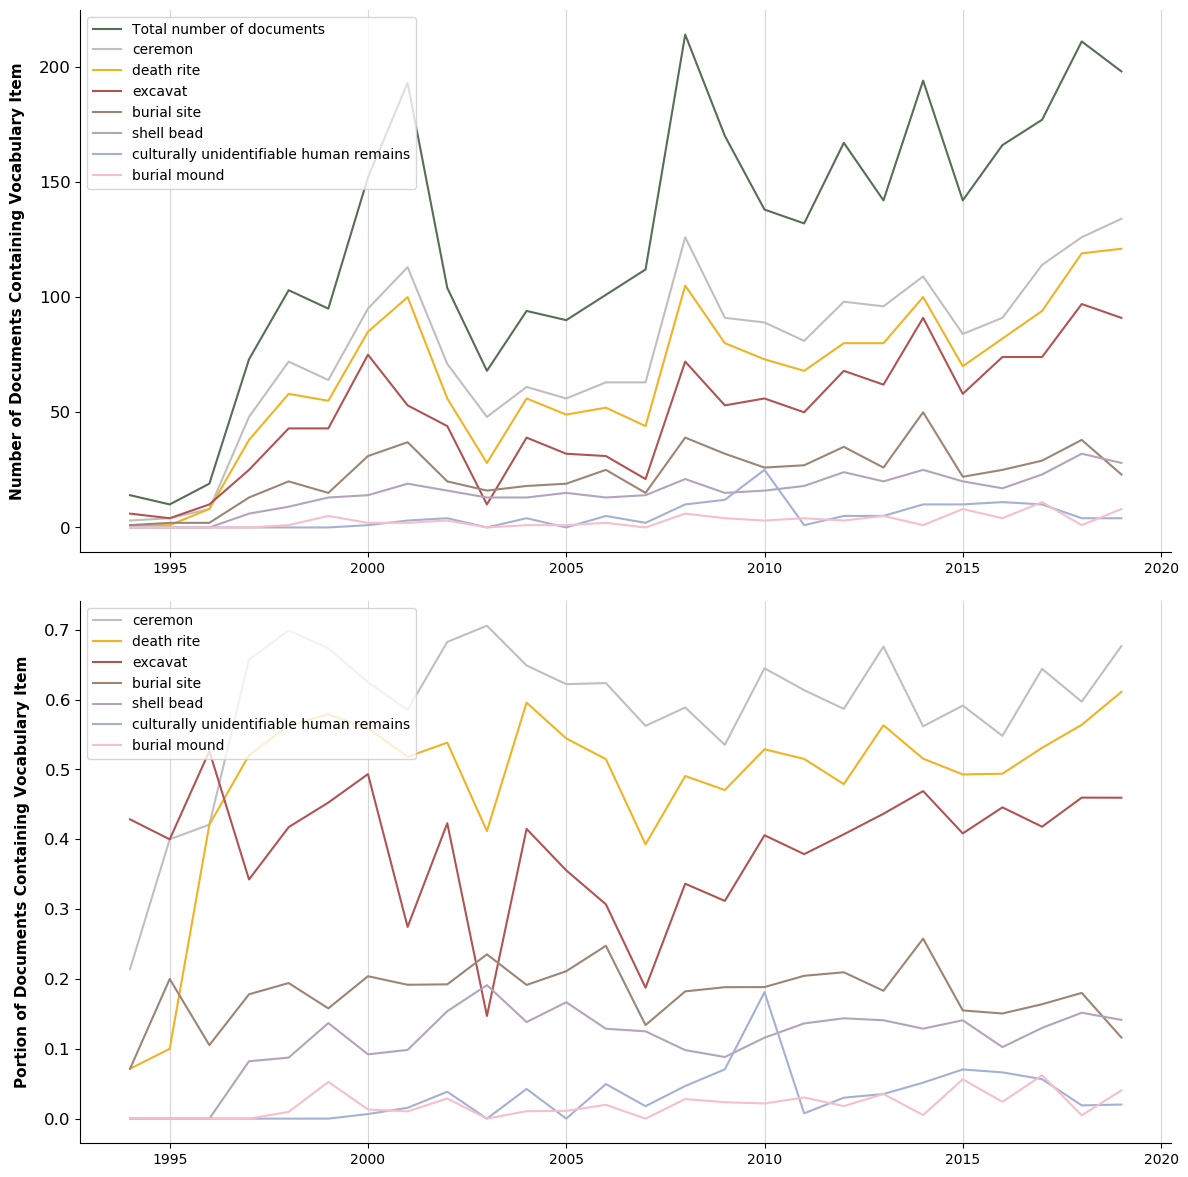

In [22]:
plot_vocab_lines(save=True)

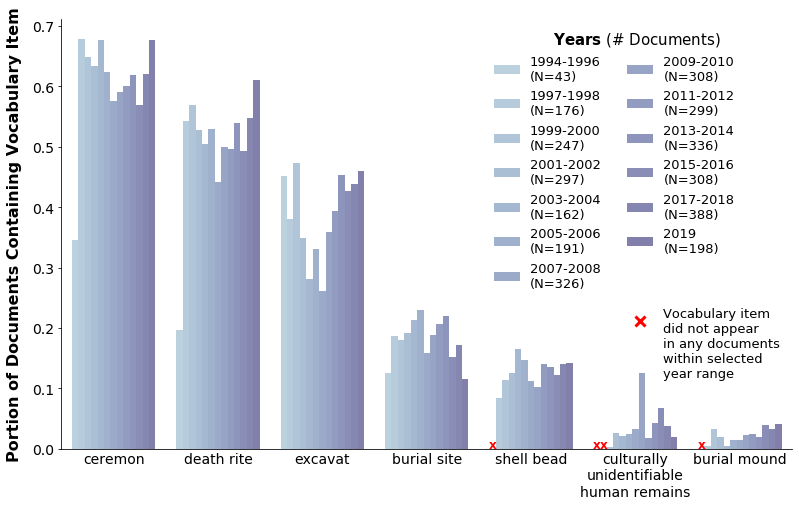

In [17]:
plot_vocab_time(np.arange(start=1994, stop=2021, step=2))

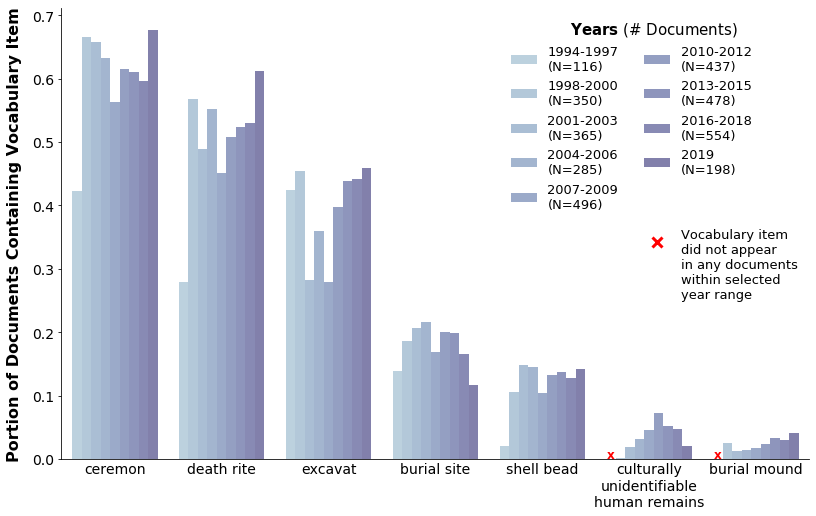

In [18]:
plot_vocab_time(np.arange(start=1994, stop=2022, step=3))

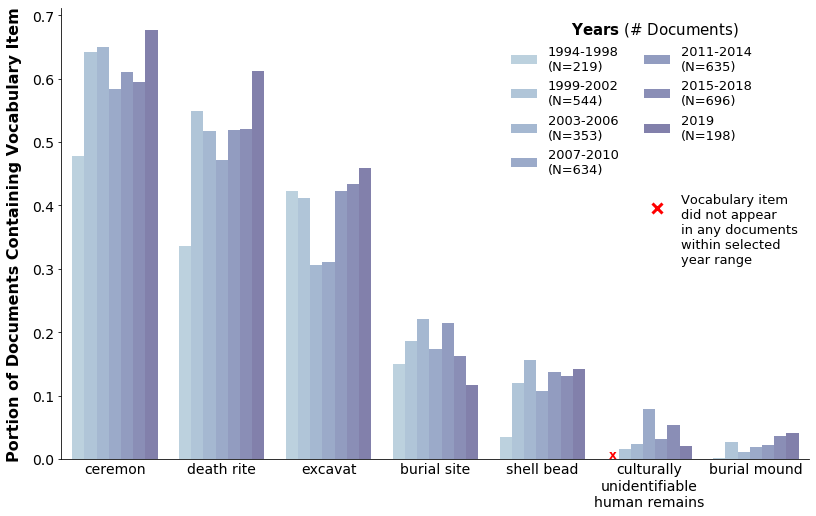

In [19]:
plot_vocab_time(np.arange(start=1994, stop=2023, step=4))

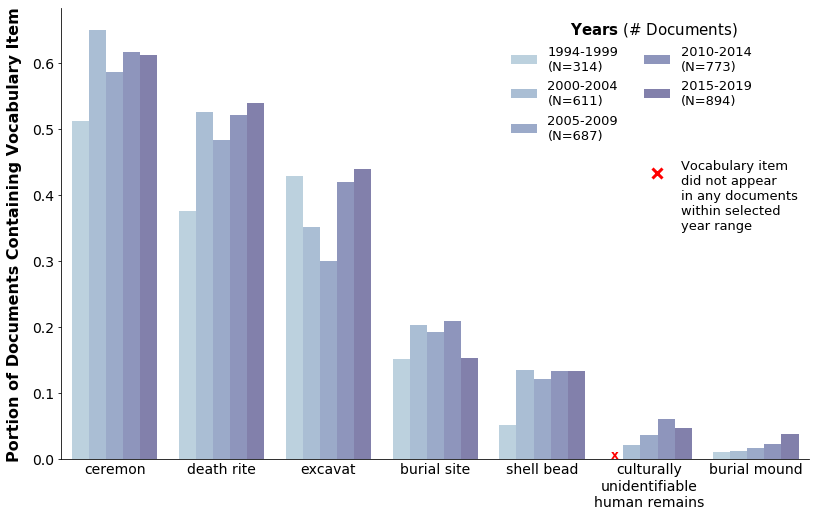

In [20]:
plot_vocab_time(np.arange(start=1994, stop=2025, step=5))

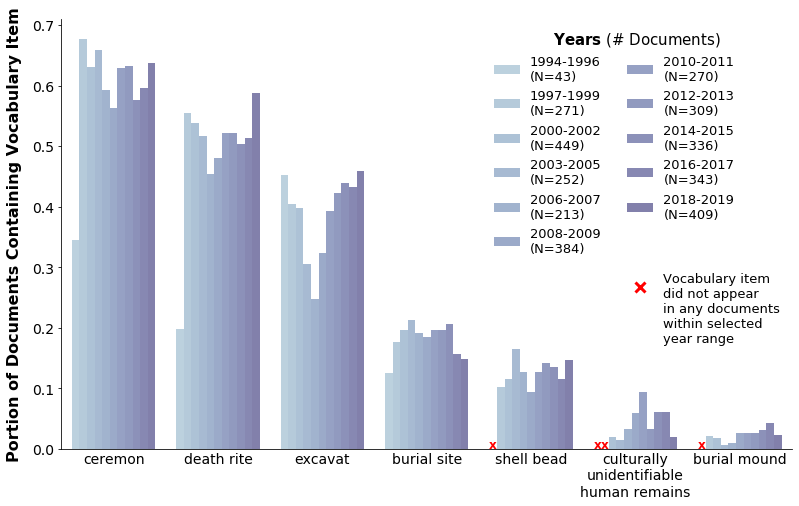

In [21]:
plot_vocab_time([1994, 1996, 1999, 2002, 2005, 2007, 2009, 2011, 2013, 2015, 2017, 2020], save=True)

In [58]:
# What about NYU? How often is "New York University" in these documents?

pd.set_option('display.max_colwidth', -1)
nyu_df = fulltext.copy()
nyu_df['nyu'] = nyu_df.messy_full.map(lambda x: "New York University" in x)
nyu_df = nyu_df[nyu_df.nyu==True]
nyu_df

messy_full  \
index                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                             